In [1]:
#importing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close'].values.reshape(-1, 1)

# Prepare the dataset
def prepare_dataset(data, look_back=50):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Parameters
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
look_back = 50
test_size = 0.2
input_dim = 1
hidden_dim = 50
num_epochs = 70
num_layers = 2
learning_rate = 0.0001
output_dim = 1
dropout_prob = 0.2  # Set dropout probability
batch_size = 64

# Fetch and scale data
raw_data = fetch_stock_data(ticker, start_date, end_date)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

# Prepare datasets
X, Y = prepare_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)  # LSTM input shape [batch_size, seq_len, input_dim]

[*********************100%%**********************]  1 of 1 completed


In [3]:
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the output of the last LSTM layer
        out = self.fc(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StockPredictor(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)


In [4]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=False)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train()
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device).view(-1, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/70], Loss: 0.1939
Epoch [20/70], Loss: 0.0223
Epoch [30/70], Loss: 0.0137
Epoch [40/70], Loss: 0.0095
Epoch [50/70], Loss: 0.0082
Epoch [60/70], Loss: 0.0084
Epoch [70/70], Loss: 0.0072


Testing Loss: 0.0041


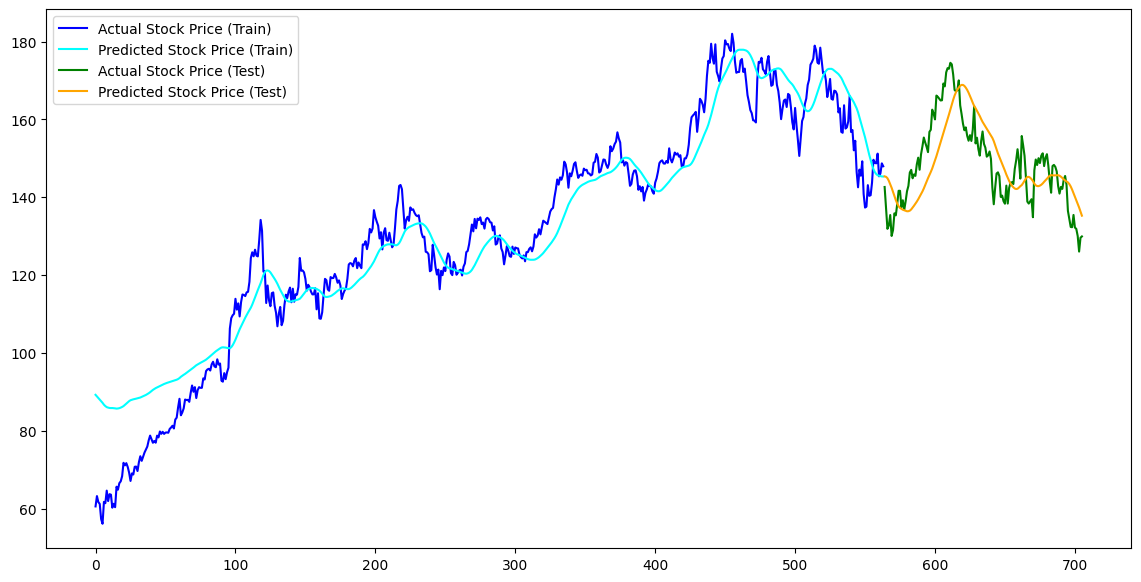

In [5]:
# Evaluate on the testing set
model.eval()
with torch.no_grad():
    test_inputs = X_test.to(device)
    test_targets = Y_test.to(device).view(-1, 1)
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Testing Loss: {test_loss.item():.4f}')

    # Bring the predictions back to the original scale for visualization
    predicted_train = model(X_train.to(device)).cpu().numpy()
    predicted_test = test_outputs.cpu().numpy()

# Inverse transform to original scale
predicted_train = scaler.inverse_transform(predicted_train)
actual_train = scaler.inverse_transform(Y_train.numpy().reshape(-1, 1))
predicted_test = scaler.inverse_transform(predicted_test)
actual_test = scaler.inverse_transform(Y_test.numpy().reshape(-1, 1))

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(actual_train)), actual_train, label='Actual Stock Price (Train)', color='blue')
plt.plot(np.arange(len(predicted_train)), predicted_train, label='Predicted Stock Price (Train)', color='cyan')
plt.plot(np.arange(len(actual_train), len(actual_train) + len(actual_test)), actual_test, label='Actual Stock Price (Test)', color='green')
plt.plot(np.arange(len(actual_train), len(actual_train) + len(predicted_test)), predicted_test, label='Predicted Stock Price (Test)', color='orange')
plt.legend()
plt.show()